In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500
img_height = 500
img_width = 500
#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. A lower dimension size with greater batch size is one of the options to try.
#3 Preparing the D

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


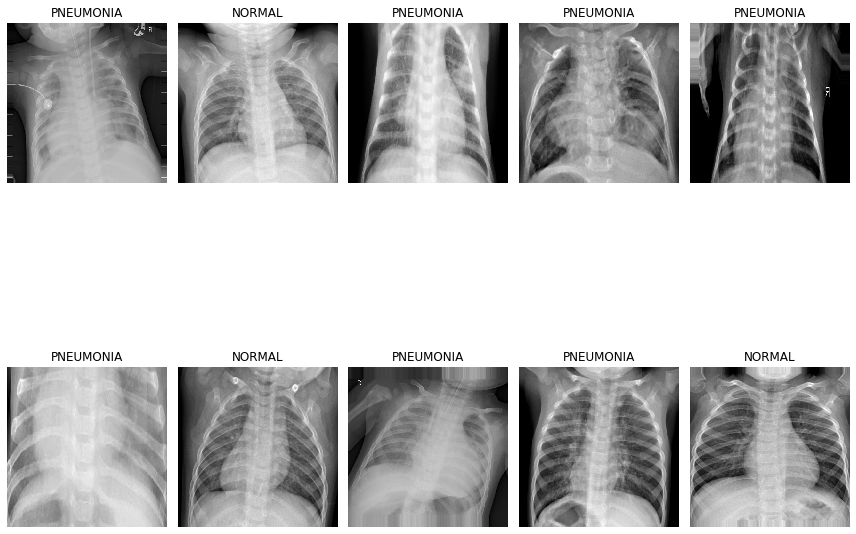

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

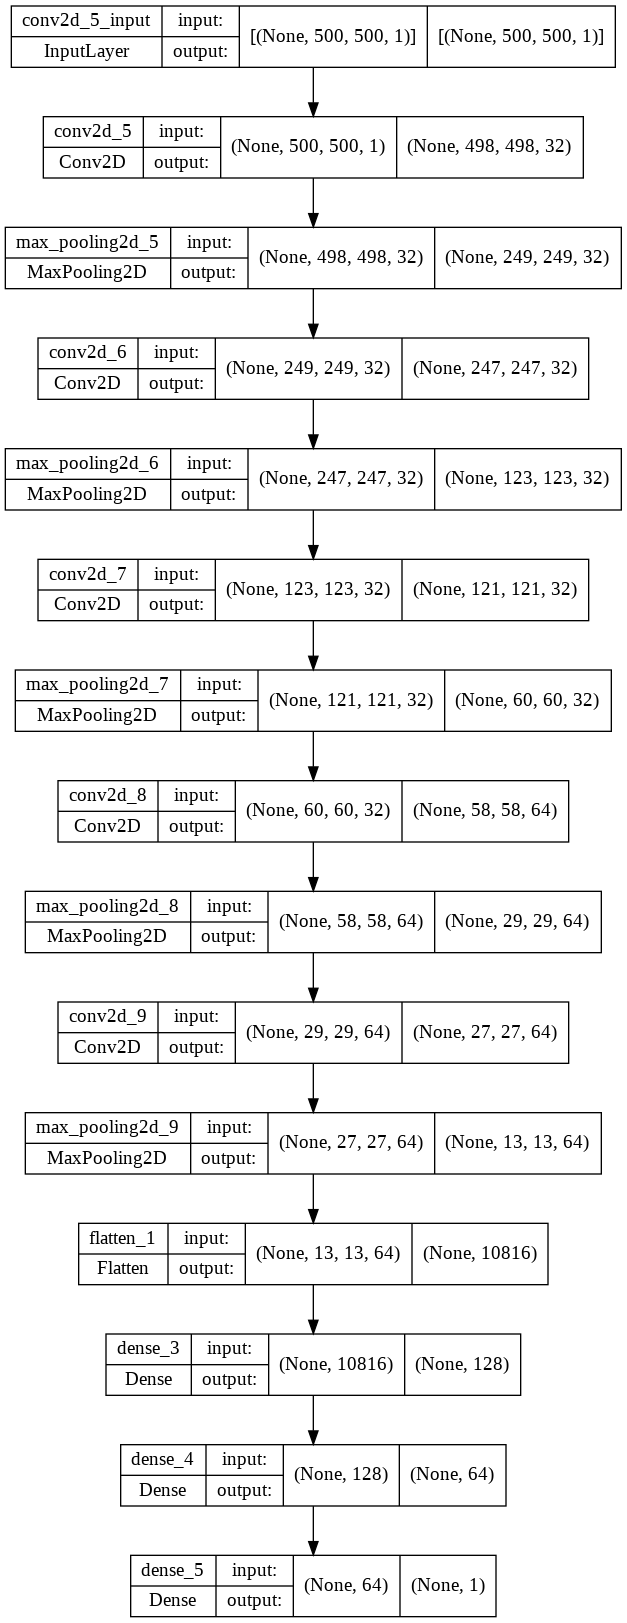

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 924s 4s/step - loss: 0.4561 - accuracy: 0.7607 - val_loss: 0.2270 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 2/25
 74/262 [=======>......................] - ETA: 10:11 - loss: 0.2946 - accuracy: 0.8775

KeyboardInterrupt: ignored

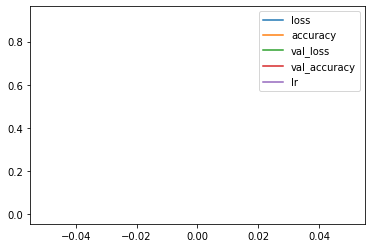

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 34s 862ms/step - loss: 0.3853 - accuracy: 0.8349
The testing accuracy is : 83.49359035491943 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 34s 856ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

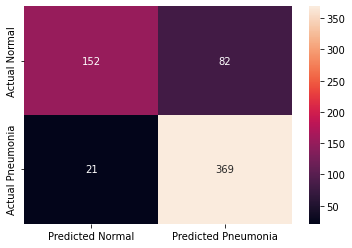

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.88      0.65      0.75       234
   PNEUMONIA       0.82      0.95      0.88       390

    accuracy                           0.83       624
   macro avg       0.85      0.80      0.81       624
weighted avg       0.84      0.83      0.83       624



(624, 500, 500, 1)
(624,)


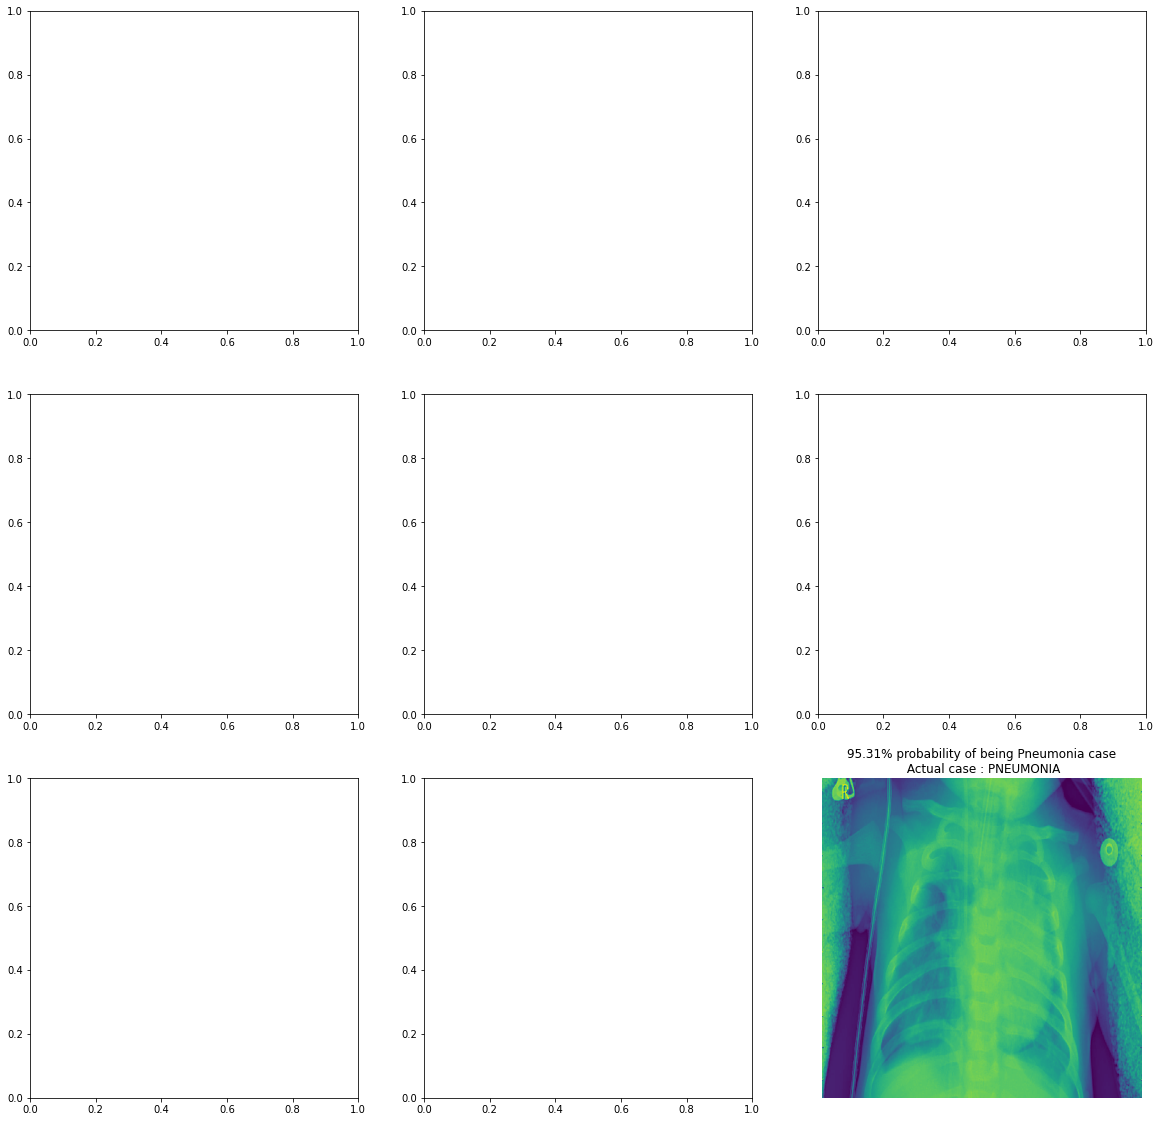

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()